# Kaggle - Titanic Survival Data Analysis


## About

This project investigated the Titanic Machine Learning from Disaster dataset from Kaggle. The following has been conducted: exploratory data analysis, statistical analysis, and prediction modeling. 

## Data and Methods 

Dataset: https://www.udacity.com/api/nodes/5420148578/supplemental_media/titanic-datacsv/download   
Website: https://www.kaggle.com/c/titanic/data

Software: Python 2.7.11 (Anaconda 2.4.1)   
Operating System: Mac OS X 10.11.2   
Hardware: Intel Core 2 Duo 2.4 GHz, 4 GB RAM

In [2]:
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

## Import Data 

The dataset was imported, and basic information (datatypes and statistics) was observed. 

In [3]:
# import into Pandas Dataframe 
raw_data = pd.read_csv('titanic_data.csv')

In [4]:
# basic information about data 
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


## Clean Data

The datatype of the "Survived' column was converted to boolean. Similarly, the datatypes of the 'Sex', 'Pclass', and 'Embarked' columns were converted to category because this data is discrete and grouped.   

In [5]:
# assign correct data types
raw_data['Survived'] = raw_data['Survived'].astype('bool')
raw_data['Pclass'] = raw_data['Pclass'].astype('category')
raw_data['Sex'] = raw_data['Sex'].astype('category')
raw_data['Embarked'] = raw_data['Embarked'].astype('category')

The 'Name' column was scraped to get the person's title. This might offer more insight beyond 'Sex'. 

In [6]:
# split out name titles and add new column 
raw_data_addtitle = raw_data.copy()
def get_title(x):
    return x.split(',')[1].split('.')[0].strip()
raw_data_addtitle['Title'] = raw_data_addtitle['Name'].apply(get_title)
raw_data_addtitle['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Title, dtype: int64

The rare titles (less than 6 frequency) were converted/renamed/grouped to simplify the analysis and have less groups. 

In [7]:
# fix rare titles and group 
title_column = raw_data_addtitle['Title'].copy()
for x in range(0, len(title_column) ):
    title_name = title_column[x]
    if title_name == 'Sir' or title_name == 'Don' or title_name == 'Mme':
        title_column[x] = 'Mr'
    elif title_name == 'Major' or title_name == 'Col' or title_name == 'Capt':
        title_column[x] = 'Navy'
    elif title_name == 'Jonkheer' or title_name == 'Lady' or title_name == 'the Countess':
        title_column[x] = 'Noble'
    elif title_name == 'Ms' or title_name == 'Mlle':
        title_column[x] = 'Miss'
raw_data_addtitle['Title-Fix'] = title_column
title_column.value_counts()

Mr        520
Miss      185
Mrs       125
Master     40
Dr          7
Rev         6
Navy        5
Noble       3
Name: Title, dtype: int64

The category columns ('Sex', 'Pclass', 'Embarked', 'Title') were made into dummy columns and added to the dataset. This was done for the modeling/machine learning completed later in the project. This changes categorical data into binary data columns. 

In [8]:
# make category variables into dummy variables/columns 
d_sex = pd.get_dummies(raw_data_addtitle['Sex']).astype('bool')
d_pclass = pd.get_dummies(raw_data_addtitle['Pclass'], prefix="P").astype('bool')
d_embarked = pd.get_dummies(raw_data_addtitle['Embarked'], prefix="Embarked").astype('bool')
d_title = pd.get_dummies(raw_data_addtitle['Title-Fix'], prefix='Title').astype('bool')
raw_data_addtitle_dummies = pd.concat([raw_data_addtitle, d_sex, d_pclass, d_embarked, d_title], 
                                      axis=1)

Removed 'Cabin', 'Ticket', and 'Name' columns because the data was formated inconsistently, sparse, or did not appear to be strongly related to survival. 

In [9]:
# remove cabin, ticket, and name columns
raw_data_remove = raw_data_addtitle_dummies.drop(['Cabin','Ticket','Name'], axis=1)

Removed observations with missing data. This was done to simplify the analysis and allow the use of prediction models. Alternatively, this data could be filled via imputation. 

In [10]:
# remove rows with missing values  
complete_data = raw_data_remove.dropna()

## Exploratory Data Analysis

The survival rate was found to be approximately 40% (288/712)

In [11]:
# percent that survived
complete_data['Survived'].mean()

0.4044943820224719

In [12]:
# number of survived
complete_data['Survived'].value_counts()

False    424
True     288
Name: Survived, dtype: int64

Sex (male/female) vs. survival rate was investigated. The female survival rate appears to be greater than the male survival rate. 

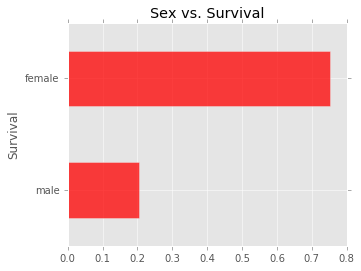

In [13]:
# sex vs. survived 
plt.rcParams['figure.figsize'] = 5,4
sex_survived_mean = complete_data.groupby('Sex')['Survived'].mean().sort_values(ascending=True)
plot1 = sex_survived_mean.plot(kind='barh', alpha=0.75, 
                               title='Sex vs. Survival', 
                               color='red')
plot1.set_ylabel("Survival")

Passenger class (P1, P2, and P3) vs. survival rate was investigated. The survival rate of the higher classes (P1 and P2) appears to be greater than the lower class (P3). (1 = 1st; 2 = 2nd; 3 = 3rd)

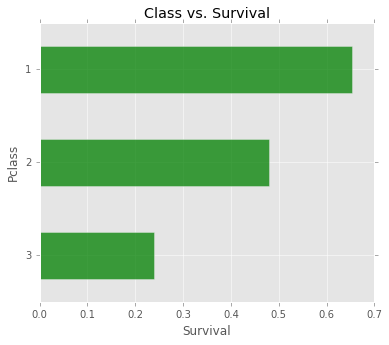

In [14]:
# class vs. survived 
plt.rcParams['figure.figsize'] = 6,5
pclass_survived_mean = complete_data.groupby('Pclass')['Survived'].mean().sort_values()
plot2 = pclass_survived_mean.plot(kind='barh', alpha=0.75, 
                                  title='Class vs. Survival', 
                                  color='green')
plot2.set_xlabel("Survival")

Embarked location (C, S, and Q) vs. survival rate was investigated. The survival rate of C appears to be greater than both S and Q. (C = Cherbourg; Q = Queenstown; S = Southampton)

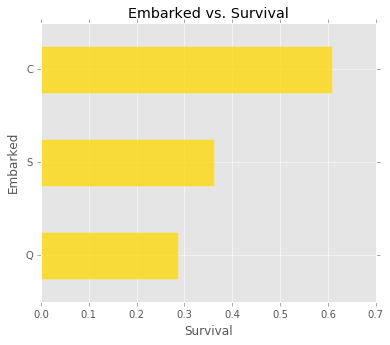

In [15]:
# Embarked vs. survived 
plt.rcParams['figure.figsize'] = 6,5
embarked_survived_mean = complete_data.groupby('Embarked')['Survived'].mean().sort_values()
plot2 = embarked_survived_mean.plot(kind='barh', alpha=0.75, 
                                    title = "Embarked vs. Survival", 
                                    color='gold')
plot2.set_xlabel("Survival")

Number of siblings/spouses aboard vs. survival rate was investigated. While there appears to be a difference between values, a consistent pattern was not observed. This plot suggested that having 1 or 2 siblings/spouses aboard increased survival, but having 3 or 4 siblings/spouses aboard decreased survival. 

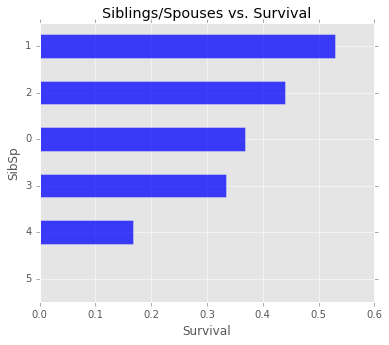

In [16]:
# SibSp vs. survived 
plt.rcParams['figure.figsize'] = 6,5
sibsp_survived_mean = complete_data.groupby('SibSp')['Survived'].mean().sort_values()
plot7 = sibsp_survived_mean.plot(kind='barh', alpha=0.75, 
                                 title = "Siblings/Spouses vs. Survival", 
                                 color='blue')
plot7.set_xlabel("Survival")

Number of parents/children vs. survival was investigated. While there appears to be a difference between values, a consistent pattern was not observed. This plot suggested that having 1-3 parents/children aboard increased survival, but having 4-6 decreased survival.  

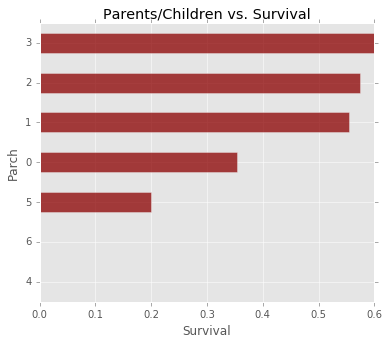

In [17]:
# Parch vs. survived 
plt.rcParams['figure.figsize'] = 6,5
parch_survived_mean = complete_data.groupby('Parch')['Survived'].mean().sort_values()
plot2 = parch_survived_mean.plot(kind='barh', alpha=0.75, 
                                 title = "Parents/Children vs. Survival", 
                                 color='darkred')
plot2.set_xlabel("Survival")

Sex, passenger class, and embarked location vs. survival rate were further investigated in groups. This plot suggested that the interaction of these variables have an effect on survival. 

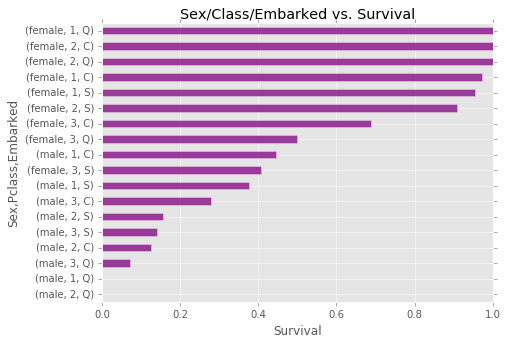

In [18]:
# sex/class/embarked vs. survived 
plt.rcParams['figure.figsize'] = 7,5
g = ['Sex','Pclass','Embarked']
sex_embarked_pclass_survived_mean = complete_data.groupby(g)['Survived'].mean().sort_values()
plot4 = sex_embarked_pclass_survived_mean.plot(kind='barh', alpha=0.75, 
                                                title="Sex/Class/Embarked vs. Survival", 
                                                color='purple')
plot4.set_xlabel("Survival")

The distribution of age vs. survival rate was investigated. There was not a clear difference between the two distributions. On the histogram, there might be is a difference at young ages. Moreover, the boxplot shows no difference. 

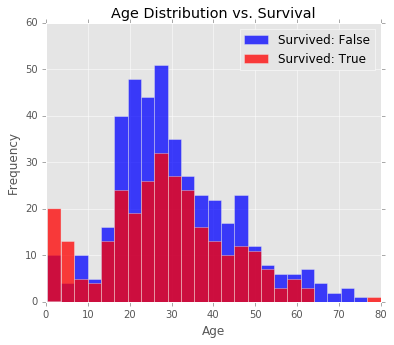

In [19]:
# histogram age vs survival
plt.rcParams['figure.figsize'] = 6,5
false_age = complete_data[complete_data['Survived'] == False]['Age'].reset_index(drop=True)
true_age = complete_data[complete_data['Survived'] == True]['Age'].reset_index(drop=True)
survived_age = pd.concat([false_age, true_age], axis=1)
survived_age.columns = ['Survived: False', 'Survived: True']
plot5 = survived_age.plot(kind='hist', alpha=0.75, bins=25, 
                          title = "Age Distribution vs. Survival", 
                          color = ['blue','red'])
plot5.set_xlabel("Age")

In [20]:
survived_age.describe()

,Survived: False,Survived: True
count,424.000000,288.000000
mean,30.626179,28.193299
std,14.172110,14.859146
min,1.000000,0.420000
25%,21.000000,19.000000
50%,28.000000,28.000000
75%,39.000000,36.000000
max,74.000000,80.000000


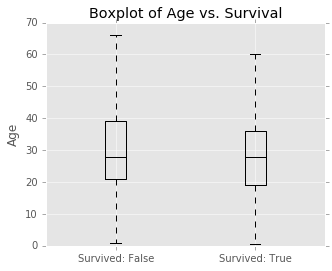

In [21]:
# boxplot age vs. survival 
plt.rcParams['figure.figsize'] = 5,4
plot5_2 = survived_age.plot(kind='box', title='Boxplot of Age vs. Survival', color='black', 
                            showfliers=False, sym='r+')
plot5_2.set_ylabel("Age")

The distribution of fare/price vs. survival rate was investigated. There was not a clear difference between the two distributions. On the histogram, there might be is a difference at low fares. The boxplot showed a larger range and higher median for survivors than non-survivors.

In [22]:
# histogram fare vs. survival
plt.rcParams['figure.figsize'] = 6,5
false_fare = complete_data[complete_data['Survived'] == False]['Fare'].reset_index(drop=True)
true_fare = complete_data[complete_data['Survived'] == True]['Fare'].reset_index(drop=True)
survived_fare = pd.concat([false_fare, true_fare], axis=1)
survived_fare.columns = ['Survived: False', 'Survived: True']

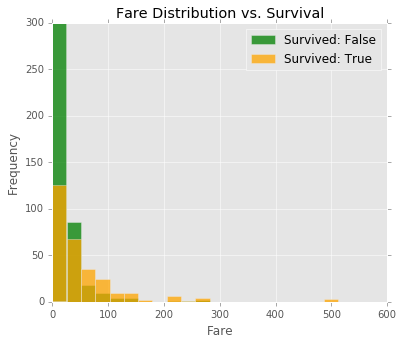

In [23]:
plot6 = survived_fare.plot(kind='hist', alpha=0.75, bins=20, 
                           title='Fare Distribution vs. Survival', 
                           color=['green','orange'])
plot6.set_xlabel("Fare")

In [24]:
survived_fare.describe()

,Survived: False,Survived: True
count,424.000000,288.000000
mean,22.965456,51.647672
std,31.448825,70.664499
min,0.000000,0.000000
25%,7.895800,13.000000
50%,11.887500,26.250000
75%,26.550000,65.000000
max,263.000000,512.329200


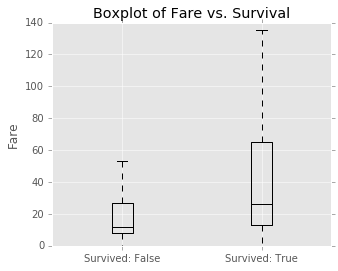

In [25]:
# boxplot fare vs. survival 
plt.rcParams['figure.figsize'] = 5,4
plot6_2 = survived_fare.plot(kind='box', title='Boxplot of Fare vs. Survival', 
                             color='black', 
                             showfliers=False, sym='r+')
plot6_2.set_ylabel("Fare")

### Correlation Matrix 

In [26]:
# correlation matrix
# source: http://stackoverflow.com/questions/29432629
def plot_corr(df,size=7):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr, cmap='bwr')
    plt.grid(False)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)

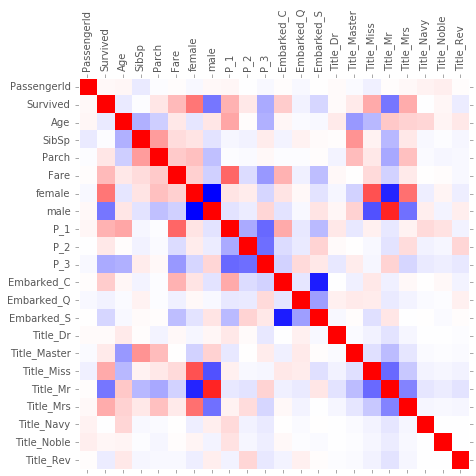

In [27]:
plot_corr(complete_data)

## Statistical Analysis

### Chi-Square Test for Categorical Data vs. Survival 

The chi-square test was used to look for significant differences in the categorical variables sex, passenger class, and embarked location vs. survival. All of these variable were found to have statistically significant differences (p < 0.05, reject null hypothesis).

In [28]:
# survived vs. sex
count_female_survived = complete_data[ complete_data['Sex'] == 'female' ]['Survived'].value_counts()
count_male_survived = complete_data[ complete_data['Sex'] == 'male' ]['Survived'].value_counts()
count_sex_survived = pd.concat([count_female_survived,count_male_survived], axis=1)
count_sex_survived.columns = ['female','male']
count_sex_survived

,female,male
False,64,360
True,195,93


In [29]:
stats.chisquare(count_sex_survived)

Power_divergenceResult(statistic=array([  66.25868726,  157.37086093]), pvalue=array([  3.95460979e-16,   4.24729554e-36]))

In [30]:
# survived vs. 3 classes
count_pc1_survived = complete_data[ complete_data['Pclass'] == 1 ]['Survived'].value_counts()
count_pc2_survived = complete_data[ complete_data['Pclass'] == 2 ]['Survived'].value_counts()
count_pc3_survived = complete_data[ complete_data['Pclass'] == 3 ]['Survived'].value_counts()
count_pc_survived = pd.concat([count_pc1_survived,count_pc2_survived,count_pc3_survived], axis=1)
count_pc_survived.columns = ['Pclass_1','Pclass_2','Pclass_3']
count_pc_survived

,Pclass_1,Pclass_2,Pclass_3
False,64,90,270
True,120,83,85


In [31]:
stats.chisquare(count_pc_survived)

Power_divergenceResult(statistic=array([ 17.04347826,   0.28323699,  96.4084507 ]), pvalue=array([  3.65336317e-05,   5.94587383e-01,   9.34673526e-23]))

In [32]:
# survived vs. embarked 
count_s_survived = complete_data[ complete_data['Embarked'] == 'S' ]['Survived'].value_counts()
count_c_survived = complete_data[ complete_data['Embarked'] == 'C' ]['Survived'].value_counts()
count_q_survived = complete_data[ complete_data['Embarked'] == 'Q' ]['Survived'].value_counts()
count_embarked_survived = pd.concat([count_s_survived,count_c_survived,count_q_survived], axis=1)
count_embarked_survived.columns = ['Embarked_S','Embarked_C','Embarked_Q']
count_embarked_survived

,Embarked_S,Embarked_C,Embarked_Q
False,353,51,20
True,201,79,8


In [33]:
stats.chisquare(count_embarked_survived)

Power_divergenceResult(statistic=array([ 41.70397112,   6.03076923,   5.14285714]), pvalue=array([  1.06193077e-10,   1.40586053e-02,   2.33422020e-02]))

### T-Test for Numerical Data vs. Survival

T-tests were conducted to look for significant differences in age, fare, siblings/spouses, and parents/children vs. survival. Significant differences were found with respect to age and parents/children (p < 0.05, reject null hypothesis). No significant difference was found with respect to fare/price and siblings/spouses. survival (p > 0.05, do not reject null hypothesis).

In [34]:
# survived vs. age
stats.ttest_ind( complete_data[ complete_data['Survived'] == True ]['Age'],
                 complete_data[ complete_data['Survived'] == False ]['Age'], 
                 equal_var=False )           

Ttest_indResult(statistic=-2.1844862149398256, pvalue=0.029314977546010718)

In [35]:
# survived vs. fare/price
stats.ttest_ind( complete_data[ complete_data['Survived'] == True ]['Fare'],
                 complete_data[ complete_data['Survived'] == False ]['Fare'], 
                 equal_var=False )         

Ttest_indResult(statistic=6.4669402027739755, pvalue=3.2142231329618292e-10)

In [36]:
# survived vs. sibsp (siblings and spouses)
stats.ttest_ind( complete_data[ complete_data['Survived'] == True ]['SibSp'],
                 complete_data[ complete_data['Survived'] == False ]['SibSp'], 
                 equal_var=False )        

Ttest_indResult(statistic=-0.44158185760313012, pvalue=0.65892640287932047)

In [37]:
# survived vs. parch (parents and children)
stats.ttest_ind( complete_data[ complete_data['Survived'] == True ]['Parch'],
                 complete_data[ complete_data['Survived'] == False ]['Parch'], 
                 equal_var=False )    

Ttest_indResult(statistic=2.5905139169253277, pvalue=0.0097986266257334299)

## Prediction Models 

### Base Model

Base prediction model is most common result (no survivors), which is aproximately 60% accurate. 

In [38]:
# base model accuracy, if no survivors
# confusion matrix
# source: http://stackoverflow.com/questions/2148543/
from sklearn.metrics import confusion_matrix
pred_bool = np.zeros(len(complete_data['Survived']))
known_bool = np.array( complete_data['Survived'].astype('bool') )
cm = confusion_matrix(known_bool, pred_bool)
# function that returns accuracy from confusion matrix
def cmatrix(x):
     return ( x[0][0] + x[1][1] ).astype(float) / ( x[0][0] + x[1][1] + x[0][1] + x[1][0] )
cmatrix(cm)

0.5955056179775281

### Logistic Regression Prediction Model

A linear/logistic regression was preformed with the variables determined to be significant above. Via trial-and-error, the coefficients of 'Age', 'Sex/Male', 'Pclass_1', 'Pclass_2', 'P_class3', 'SibSp', 'Title_Master', and 'Title_Miss' were found to significant (95% CI does not include 0). Note: this is likely just one of various models. Due to the interaction of variables, different combinations of variables change the coefficients that appear to be significant. Also, this is likely not the best or optimal model. It is just one of many combinations of significant variable coefficients. 

In [39]:
# logistic regression model 
# source: http://blog.yhat.com/posts/logistic-regression-and-python.html
# source: http://stackoverflow.com/questions/23048690/how-to-fit-a-model-to-my-testing-set-in-statsmodels-python
import statsmodels.api as sm
model_data = complete_data.drop(['PassengerId','Pclass','Sex','female',
                                 'Embarked','Title','Title-Fix'], axis=1) 
logit = sm.Logit( model_data['Survived'], 
                  model_data[['male','Age','P_1','P_2','P_3','SibSp',
                              'Title_Master','Title_Miss']].astype(float) )
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.417442
         Iterations 6


In [40]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Sun, 07 Feb 2016   Pseudo R-squ.:                  0.3814
Time:                        00:12:11   Log-Likelihood:                -297.22
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 3.670e-75
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
male            -3.4622      0.318    -10.896      0.000        -4.085    -2.839
Age             -0.0343      0.010     -3.572      0.000        -0.053    -0.015
P_1              4.7287      0.590      8.02

In [41]:
# logistic model confusion matrix
v = ['male','Age','P_1','P_2','P_3', 'SibSp','Title_Master','Title_Miss']
pred = np.array( result.predict( model_data[v].astype('float')) )
pred_bool = pred > 0.5
known_bool = np.array( model_data['Survived'].astype('bool') )
cm2 = confusion_matrix(known_bool, pred_bool)
cm2

array([[369,  55],
       [ 65, 223]])

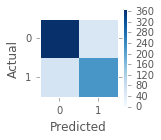

In [42]:
# plot confusion matrix
plt.rcParams['figure.figsize'] = 1.75,1.75
plt.matshow(cm2, fignum=False, cmap='Blues', vmin=0, vmax=369)
ax = plt.axes()
ax.xaxis.set_ticks_position("bottom")
plt.colorbar()
plt.grid(False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

The accuracy of the logistic model was found to be approximately 83%. An improvement of about 23% over the base model. 

In [43]:
# logistic model accuracy 
cmatrix(cm2)

0.8314606741573034

### Random Forest Prediction Model 


A random forest model was preformed with all variables.  

In [44]:
# random forest with all variables 
# source: www.kaggle.com/c/titanic/details/getting-started-with-random-forests
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 100)
rf_data = model_data.drop(['Survived'], axis=1)
forest = forest.fit(rf_data,
                    model_data['Survived'])
output = forest.predict(rf_data.astype(float))

In [45]:
# random forest full confusion matrix 
cm3 = confusion_matrix(known_bool, output)
cm3

array([[422,   2],
       [  6, 282]])

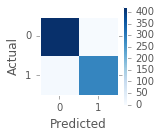

In [46]:
# plot confusion matrix
plt.rcParams['figure.figsize'] = 1.75,1.75
plt.matshow(cm3, fignum=False, cmap='Blues', vmin=0, vmax=422)
ax = plt.axes()
ax.xaxis.set_ticks_position("bottom")
plt.colorbar()
plt.grid(False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

The accuracy of the full random forest model was approximately 99%. An improvement of 39% over the base model. 

In [47]:
# random forest full model accuracy
cmatrix(cm3)

0.9887640449438202

The most important variables in the full random forest model were found to be 'Age', 'Fare', 'Title_Mr', 'Sex/male', and 'Pclass 3'. 

In [48]:
# random forest variable importance 
# source: scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
plt.rcParams['figure.figsize'] = 8,6
importances = forest.feature_importances_
varimp = pd.Series( importances, index=rf_data.columns).sort_values(ascending=True)

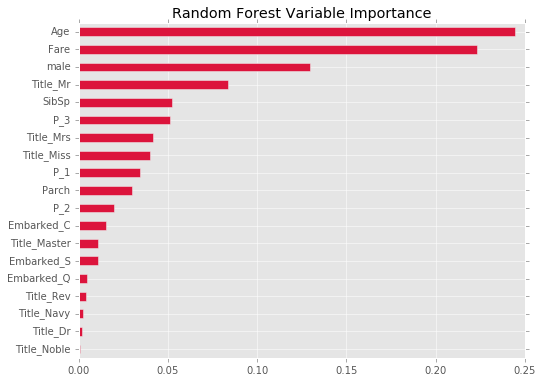

In [49]:
varimp.plot(kind='barh', title='Random Forest Variable Importance', color='Crimson')

## Conclusions 

### Exploratory Data Analysis 

This exploratory data analysis of the Titanic dataset suggested that the following conditions made it more likely to survive: being female, having a higher class passenger ticket (1 or 2), and embarking from Southampton or Cherbourg. It is important to note that these variables appear to be correlated/related to higher survival and this is no indication of causation. Also, due to the large number of variables and possible interactions, it is difficult to find relationship/correlations when looking at only a few (1-3) variables at a time. 

### Statistical Data Analysis 

The statistical analysis of the Titanic dataset found significant differences (p < 0.05) in survival due to sex, passenger class ticket, embarking location, age, and parents/children aboard. It was determined that the following conditions made it more likely to survive: being female, having a higher class passenger ticket (1 or 2), embarking from Southampton or Cherbourg, being younger, and having more parents/children aboard. It is important to note that these variables were investigated individually and were not in controlled groups (all other variables were not held constant). Finally, the interactions of these variables were not considered, which would likely result in different conclusions. Nevertheless, these results made intuitive sense and contributed to the development of prediction models. 

### Simplifications and Limitations 

To simplify this analysis, two columns 'Cabin' and 'Ticket' were removed due to sparse/missing data and inconsistent formating. The 'Cabin' data need to be further investigated and included in the analysis. Missing values ('Age', 'Cabin', and 'Embarked') could potentially be imputed using models built from the other variables. Moreover, the siblings/spouse and parents/children variables do not show connections/networks between the individuals; this could potentially be added to look for patterns. Additional data, which might have improved this analysis, are education, occupation, and marital status. 

### Next Steps

- Prediction models need to be tested with outside data (test set) to properly determine accuracy 
- Random forest model needs to be refined to avoid overfitting (remove unnecessary variables)
- Investigate variable columns 'Cabin' and 'Ticket' and create additional features 
- Consider transforming siblings/spouses and parents/children data in category/ordinal datatypes 
- Consider imputation of missing values 